# Figure (and Table) Generation Notebook

This notebook generates figures used in the article and for presentations. Some of these figures can be generated directly, while others require simulation results to have been run and saved beforehand. The different sections are independent from one another, which explains the multiple imports.

In [1]:
path_article = "../../présentation/article/"

## Target

### True Target

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



Text(0.5, 1.56, 'Target R \n (Equidistant nodes)')

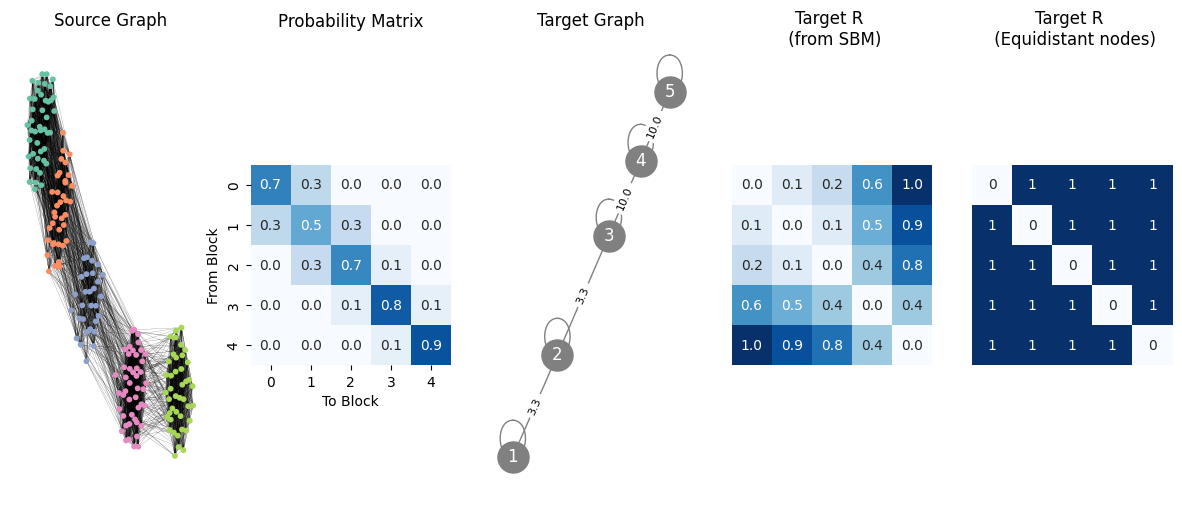

In [2]:
from src.shapes import MixingMatrix
from src.distances import distance_graph
from src.simulation.utils import ct_group
from src.simulation.graph import SimulatedGraph
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import numpy as np
groups_details = ct_group(200, 5, 20)

n = 200
k = 5
structure_force = 0.2
inter_group = 0.1
cmap = 'Blues'
vmin, vmax = 0, 1


# create mixing matrices
matrices = dict()
mixingM = MixingMatrix([],k,structure_force)

matrices['fully connected'] = mixingM.define_mixing_matrix_ref(inter_group,[]) # fully connected
matrices['sparse'] = mixingM.define_mixing_matrix_sparse(inter_group) # sparse
matrices['chain'] = mixingM.define_mixing_matrix_chain(inter_group) # chain
matrices['donut'] = mixingM.define_mixing_matrix_donut(inter_group) # donut
matrices['star'] = mixingM.define_mixing_matrix_star(inter_group) # star

# create graphs
graphs = dict()
for key in matrices.keys():
    graphs[key] = SimulatedGraph(groups=groups_details,
                                 type_graph=key,
                                 structure_strength=structure_force, 
                                 mixing_matrix=matrices[key]) 

fig, axes = plt.subplots(1, 5, figsize=(15, 6))
type_m = "chain"

### Graphe
colors = graphs[type_m].get_colors()
nx.draw(graphs[type_m].graph, with_labels=False, node_size=10, width = 0.1, node_color=colors, ax=axes[0])


### Heatmap 2
sns.heatmap(matrices[type_m], cmap=cmap, vmin=vmin, vmax=vmax, ax=axes[1], cbar=False, square=True, annot=True, fmt=".1f",)
axes[1].set_xlabel("To Block")
axes[1].set_ylabel("From Block")

### Coarsened graph
G = nx.from_numpy_array(matrices[type_m], create_using=nx.Graph)
mapping = {old_label: old_label + 1 for old_label in G.nodes()}
G = nx.relabel_nodes(G, mapping)
for u, v, d in G.edges(data=True):
    d['weight'] = round(1/round(matrices[type_m][u-1, v-1],1),1)
edge_weights = nx.get_edge_attributes(G, 'weight')

pos = nx.spring_layout(G)
nx.draw(G, pos, node_color='grey', with_labels=True, edge_color='gray', node_size=500, ax=axes[2], font_color = "white")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, font_color='black', ax=axes[2], font_size=8, label_pos=0.5)


c2 = distance_graph(G, weight="weight")
sns.heatmap(c2, cmap=cmap, vmin=vmin, vmax=vmax, ax=axes[3], cbar=False, square=True, annot=True, fmt=".1f",)
axes[3].set_xticks([])
axes[3].set_yticks([])

target_graph = nx.from_numpy_array(np.identity(k))
target_c = nx.floyd_warshall_numpy(target_graph)
target_c = np.nan_to_num(target_c, posinf=1)
sns.heatmap(target_c, cmap=cmap, vmin=vmin, vmax=vmax, ax=axes[4], cbar=False, square=True, annot=True)
axes[4].set_xticks([])
axes[4].set_yticks([])

axes[0].set_title("Source Graph", y=1)
axes[1].set_title("Probability Matrix", y=1.65)
axes[2].set_title("Target Graph", y=1)
axes[3].set_title("Target R \n (from SBM)", y=1.56)
axes[4].set_title("Target R \n (Equidistant nodes)", y=1.56)

### Target Matrices

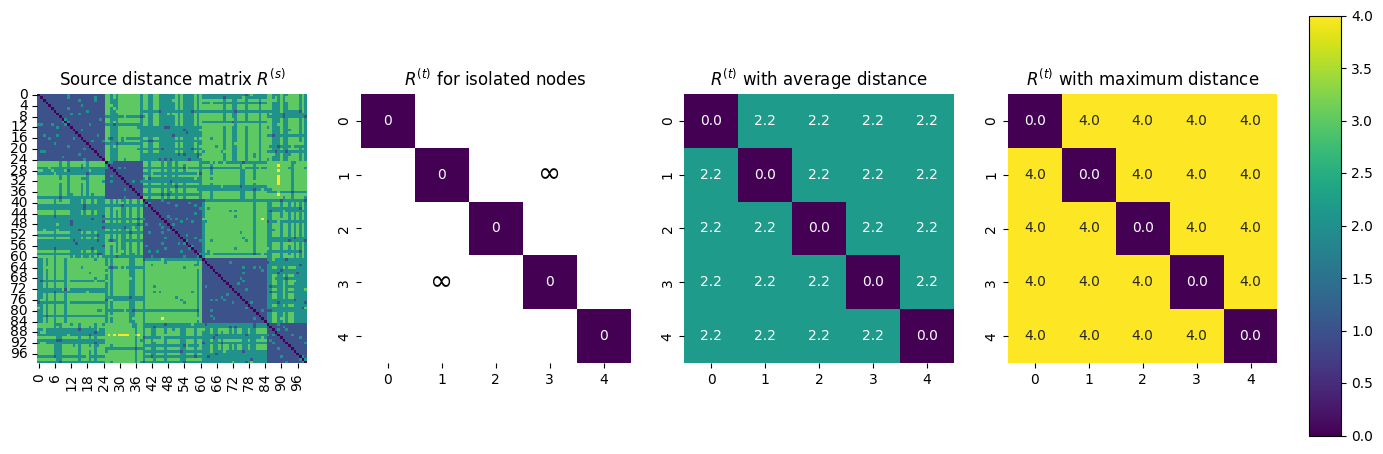

In [3]:
from src.simulation.graph import SimulatedGraph
from src.distances import distance_graph
from src.simulation.utils import ct_group
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize

n=100
k=5
groups = ct_group(n, k)
g = SimulatedGraph(groups, "ref", 2)
a = distance_graph(g.graph, normalized=False)
vmin = np.min(a)
vmax = np.max(a)

target_C_mean = np.full((k,k), np.mean(a)) - np.mean(a)*np.identity(k)
target_C_max = np.full((k,k), np.max(a)) - np.max(a)*np.identity(k)

dist_matrix = np.full((k,k), np.inf)
np.fill_diagonal(dist_matrix, 0)
dist_matrix_plot = np.where(dist_matrix == np.inf, np.nan, 0)

fig, axes = plt.subplots(1, 4, figsize=(16, 6))

# Heatmaps
sns.heatmap(a, square=True, cmap="viridis", vmin=vmin, vmax=vmax, cbar=False, ax=axes[0])
sns.heatmap(dist_matrix_plot, square=True, cmap="viridis", annot=True, fmt='.0f', cbar=False, ax=axes[1])
axes[1].text(3 + 0.5, 1 + 0.5, "∞", color="black", fontsize=20,
        ha='center', va='center')
axes[1].text(1 + 0.5, 3 + 0.5, "∞", color="black", fontsize=20,
        ha='center', va='center')
sns.heatmap(target_C_mean, square=True, cmap="viridis", vmin=vmin, vmax=vmax, annot=True, fmt=".1f", cbar=False, ax=axes[2])
sns.heatmap(target_C_max, square=True, cmap="viridis", vmin=vmin, vmax=vmax, annot=True, fmt=".1f", cbar=False, ax=axes[3])
axes[0].set_title('Source distance matrix $R^{(s)}$')
axes[1].set_title('$R^{(t)}$ for isolated nodes')
axes[2].set_title('$R^{(t)}$ with average distance')
axes[3].set_title('$R^{(t)}$ with maximum distance')

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
norm = Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])  # nécessaire pour ScalarMappable
fig.colorbar(sm, cax=cbar_ax)


### Noisy version

100%|██████████| 30/30 [00:05<00:00,  5.97it/s]


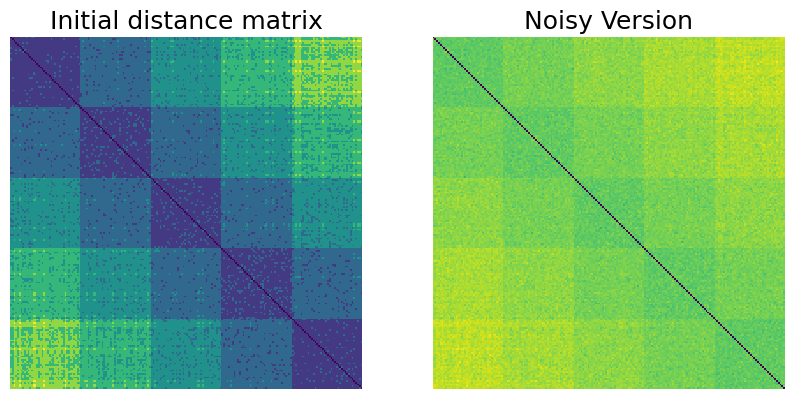

In [4]:
import numpy as np
from src.simulation.graph import SimulatedGraph
from src.distances import distance_graph
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

k = 5
n = 200
type_graph = 'chain'
structure_force = 1
groups = np.array([40, 40, 40, 40, 40])
#groups = np.array([10, 70, 40, 10, 70])
graph_equilibre = SimulatedGraph(groups, type_graph=type_graph, structure_strength=structure_force)
distances_matrix = distance_graph(graph_equilibre.graph)

seed = 0
np.random.seed(seed)
ref = distances_matrix
#upper_noise = np.random.beta(a=0.1, b=0.5, size=(n,n))
upper_noise = np.random.normal(loc=3, scale=.1, size=(n,n))
noise = np.triu(upper_noise, 1)
noise = noise + noise.T
noisy_ref = noise + ref
noisy_ref = noisy_ref/noisy_ref.max()

from sklearn.metrics import adjusted_rand_score
from tqdm import tqdm
import pandas as pd
from src.clustering.init_strategies import ClusteringInit
from src.clustering.gw_clustering import SemiRelaxedGWClustering

true_labels = graph_equilibre.get_true_labels()

results = {'srgw':{'srGW (MEAN)':[],'srGW (MAX)':[]}}
applied_matrix = ref

init = ClusteringInit(n, k, applied_matrix, set_seed=seed)
for i in tqdm(range(30)):
    _, init_OT_kernel = init.embedded_kmeanspp_init()
    srgw_mean = SemiRelaxedGWClustering(n, k, g0=init_OT_kernel, value=np.mean(applied_matrix))
    labels_noisy_mean = srgw_mean.partitioning_simple(applied_matrix)['labels']
    results['srgw']['srGW (MEAN)'].append(adjusted_rand_score(true_labels,labels_noisy_mean))

    srgw_max = SemiRelaxedGWClustering(n, k, g0=init_OT_kernel, value=np.max(applied_matrix))
    labels_noisy_max = srgw_max.partitioning_simple(applied_matrix)['labels']
    results['srgw']['srGW (MAX)'].append(adjusted_rand_score(true_labels,labels_noisy_max))

rows = []
for method, targets in results.items():
    for target, values in targets.items():
        for i, v in enumerate(values):
            rows.append({
                "method": method,
                "target": target,
                "value": v
            })
df_base = pd.DataFrame(rows)
df_base['type'] = 'Initial'

results = {'srgw':{'srGW (MEAN)':[],'srGW (MAX)':[]}}
applied_matrix = noisy_ref
init = ClusteringInit(n, k, applied_matrix, set_seed=seed)
for i in tqdm(range(30)):
    _, init_OT_kernel = init.embedded_kmeanspp_init()
    srgw_mean = SemiRelaxedGWClustering(n, k, g0=init_OT_kernel, value=np.mean(applied_matrix))
    labels_noisy_mean = srgw_mean.partitioning_simple(applied_matrix)['labels']
    results['srgw']['srGW (MEAN)'].append(adjusted_rand_score(true_labels,labels_noisy_mean))

    srgw_max = SemiRelaxedGWClustering(n, k, g0=init_OT_kernel, value=np.max(applied_matrix))
    labels_noisy_max = srgw_max.partitioning_simple(applied_matrix)['labels']
    results['srgw']['srGW (MAX)'].append(adjusted_rand_score(true_labels,labels_noisy_max))

rows = []
for method, targets in results.items():
    for target, values in targets.items():
        for i, v in enumerate(values):
            rows.append({
                "method": method,
                "target": target,
                "value": v
            })
df_noisy = pd.DataFrame(rows)
df_noisy['type'] = 'Noisy'

df = pd.concat([df_base, df_noisy])

sns.set_context("notebook", font_scale=1.5)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(ref, square=True, cmap="viridis", ax=axes[0], cbar=False)
axes[0].set_title("Initial distance matrix")
axes[0].set_axis_off()

sns.heatmap(noisy_ref, square=True, cmap="viridis", ax=axes[1], cbar=False)
axes[1].set_title("Noisy Version")
axes[1].set_axis_off()
#fig.savefig(f"{path_article}noisy_mean_max_light.png", dpi=300, bbox_inches='tight')

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:09<00:00,  3.24it/s]


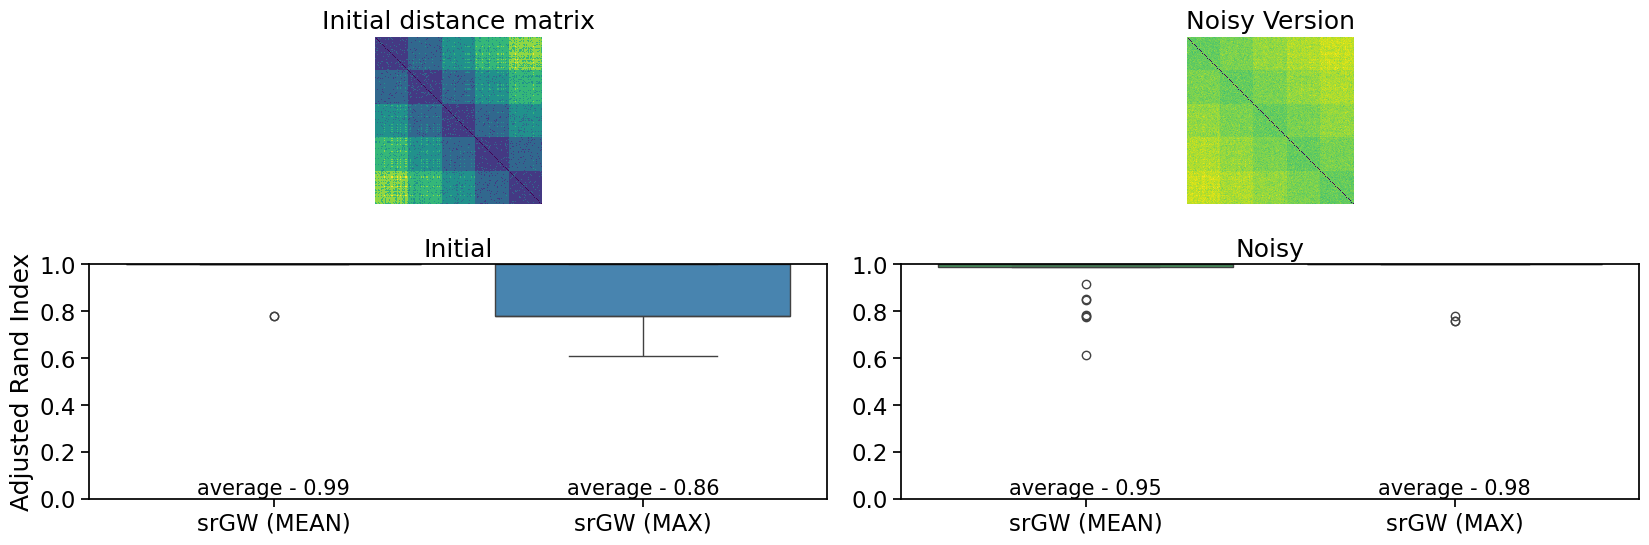

In [5]:
k = 5
n = 200
type_graph = 'chain'
structure_force = 1
groups = np.array([40, 40, 40, 40, 40])
#groups = np.array([10, 70, 40, 10, 70])
graph_equilibre = SimulatedGraph(groups, type_graph=type_graph, structure_strength=structure_force)
distances_matrix = distance_graph(graph_equilibre.graph)

seed = 0
np.random.seed(seed)
ref = distances_matrix
#upper_noise = np.random.beta(a=0.1, b=0.5, size=(n,n))
upper_noise = np.random.normal(loc=3, scale=.1, size=(n,n))
noise = np.triu(upper_noise, 1)
noise = noise + noise.T
noisy_ref = noise + ref
noisy_ref = noisy_ref/noisy_ref.max()

from sklearn.metrics import adjusted_rand_score
from tqdm import tqdm
import pandas as pd
from src.clustering.init_strategies import ClusteringInit
from src.clustering.gw_clustering import SemiRelaxedGWClustering

true_labels = graph_equilibre.get_true_labels()

results = {'srgw':{'srGW (MEAN)':[],'srGW (MAX)':[]}}
applied_matrix = ref

init = ClusteringInit(n, k, applied_matrix, set_seed=seed)
for i in tqdm(range(30)):
    _, init_OT_kernel = init.embedded_kmeanspp_init()
    srgw_mean = SemiRelaxedGWClustering(n, k, g0=init_OT_kernel, value=np.mean(applied_matrix))
    labels_noisy_mean = srgw_mean.partitioning_simple(applied_matrix)['labels']
    results['srgw']['srGW (MEAN)'].append(adjusted_rand_score(true_labels,labels_noisy_mean))

    srgw_max = SemiRelaxedGWClustering(n, k, g0=init_OT_kernel, value=np.max(applied_matrix))
    labels_noisy_max = srgw_max.partitioning_simple(applied_matrix)['labels']
    results['srgw']['srGW (MAX)'].append(adjusted_rand_score(true_labels,labels_noisy_max))

rows = []
for method, targets in results.items():
    for target, values in targets.items():
        for i, v in enumerate(values):
            rows.append({
                "method": method,
                "target": target,
                "value": v
            })
df_base = pd.DataFrame(rows)
df_base['type'] = 'Initial'

results = {'srgw':{'srGW (MEAN)':[],'srGW (MAX)':[]}}
applied_matrix = noisy_ref
init = ClusteringInit(n, k, applied_matrix, set_seed=seed)
for i in tqdm(range(30)):
    _, init_OT_kernel = init.embedded_kmeanspp_init()
    srgw_mean = SemiRelaxedGWClustering(n, k, g0=init_OT_kernel, value=np.mean(applied_matrix))
    labels_noisy_mean = srgw_mean.partitioning_simple(applied_matrix)['labels']
    results['srgw']['srGW (MEAN)'].append(adjusted_rand_score(true_labels,labels_noisy_mean))

    srgw_max = SemiRelaxedGWClustering(n, k, g0=init_OT_kernel, value=np.max(applied_matrix))
    labels_noisy_max = srgw_max.partitioning_simple(applied_matrix)['labels']
    results['srgw']['srGW (MAX)'].append(adjusted_rand_score(true_labels,labels_noisy_max))

rows = []
for method, targets in results.items():
    for target, values in targets.items():
        for i, v in enumerate(values):
            rows.append({
                "method": method,
                "target": target,
                "value": v
            })
df_noisy = pd.DataFrame(rows)
df_noisy['type'] = 'Noisy'

df = pd.concat([df_base, df_noisy])

sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[.5, .7], wspace=0.1, hspace=0.3)

custom_palette = {
    "srGW (MAX)": sns.color_palette("Blues", 2)[:2][1],
    "srGW (MEAN)": sns.color_palette("Greens", 2)[:2][1]
}  
ax0 = fig.add_subplot(gs[0, 0])
sns.heatmap(ref, square=True, cmap="viridis", ax=ax0, cbar=False)
ax0.set_title("Initial distance matrix")
ax0.set_axis_off()

ax1 = fig.add_subplot(gs[0, 1])
sns.heatmap(noisy_ref, square=True, cmap="viridis", ax=ax1, cbar=False)
ax1.set_title("Noisy Version")
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[1, 0])
df_tmp = df[df['type']=="Initial"]
sns.boxplot(data=df_tmp, x="target", y="value", hue='target', ax=ax2, palette=custom_palette)
for i, target in enumerate(df_tmp['target'].unique()):
    median_val = df_tmp[df_tmp['target']==target]['value'].mean()
    ax2.text(i, 0.02, f"average - {median_val:.2f}", ha='center', color='black', fontsize=15)
ax2.set_xlabel('')
ax2.set_ylabel('Adjusted Rand Index')
ax2.set_title("Initial")
ax2.set_ylim(0, 1)

ax3 = fig.add_subplot(gs[1, 1])
df_tmp = df[df['type']=="Noisy"]
sns.boxplot(data=df_tmp, x="target", y="value", hue='target', ax=ax3, palette=custom_palette)
for i, target in enumerate(df_tmp['target'].unique()):
    median_val = df_tmp[df_tmp['target']==target]['value'].mean()
    ax3.text(i, 0.02, f"average - {median_val:.2f}", ha='center', color='black', fontsize=15)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title("Noisy")
ax3.set_ylim(0, 1)

plt.show()
#fig.savefig(f"{path_article}noisy_mean_max.png", dpi=300, bbox_inches='tight')

## Structure Strength Illustration

Text(0.5, 1.0, 'Graph structure strength $t=5$')

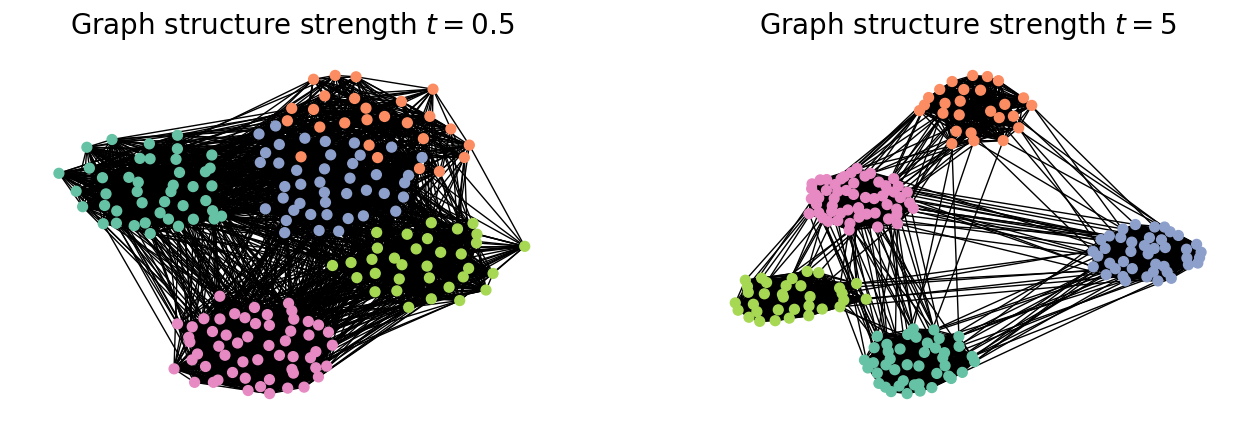

In [6]:
from src.simulation.graph import SimulatedGraph
from src.simulation.utils import ct_group
import networkx as nx

n=200
k=5
groups = ct_group(n, k)
g05 = SimulatedGraph(groups, "ref", 0.5)
g5 = SimulatedGraph(groups, "ref", 5)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
nx.draw(g05.graph, node_color=g05.get_colors(), ax=axes[0], node_size=50)
axes[0].set_title('Graph structure strength $t=0.5$', fontsize=20)
nx.draw(g5.graph, node_color=g05.get_colors(), ax=axes[1], node_size=50)
axes[1].set_title('Graph structure strength $t=5$', fontsize=20)


Text(0.5, 1.0, '$t=5$')

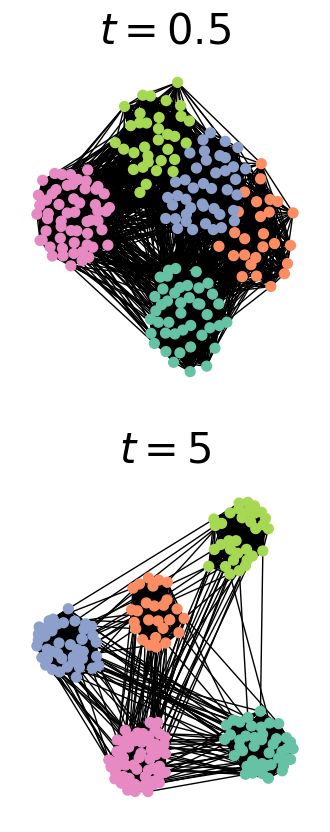

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(4, 10))
nx.draw(g05.graph, node_color=g05.get_colors(), ax=axes[0], node_size=50)
axes[0].set_title('$t=0.5$', fontsize=30)
nx.draw(g5.graph, node_color=g05.get_colors(), ax=axes[1], node_size=50)
axes[1].set_title('$t=5$', fontsize=30)


## Non attributed results
**Warning:** The following cells require that simulations have been run beforehand.
### Non embedded

In [ ]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

path = "path_to_non_attributed_results/balanced_graph/"
pattern = os.path.join(path, f"*.csv")
date_files = glob.glob(pattern)
balanced_graph = pd.concat((pd.read_csv(f) for f in date_files), ignore_index=True)
balanced_graph['balanced'] = 'balanced'

path = "path_to_non_attributed_results/unbalanced_graph/"
pattern = os.path.join(path, f"*.csv")
date_files = glob.glob(pattern)
unbalanced_graph = pd.concat((pd.read_csv(f) for f in date_files), ignore_index=True)
unbalanced_graph['balanced'] = 'unbalanced'

unattributed_graph = pd.concat([balanced_graph, unbalanced_graph])
unattributed_graph[['method','init']] = unattributed_graph['method'].str.rsplit(' - ', n=1, expand=True)

kernel_methods = ['Kernel srGW - isolated nodes (max)',
                  'Kernel srGW - isolated nodes (mean)',
                  'Kernel srGW true target']
non_kernel_methods = set(unattributed_graph['method'].unique()) - set(kernel_methods)
unattributed_graph = unattributed_graph[((unattributed_graph['method'].isin(kernel_methods)) & 
                                              (unattributed_graph['init'] == 'kernel kernel kmeans++ init')) |
                                             ((unattributed_graph['method'].isin(non_kernel_methods)) & 
                                              (unattributed_graph['init'] == 'kernel kmeans++ init')) ].copy()
unattributed_graph['kernel'] = unattributed_graph['method'].str.contains('Kernel')

Text(0.4, 0.06, 'Graph structure strength ($t$)')

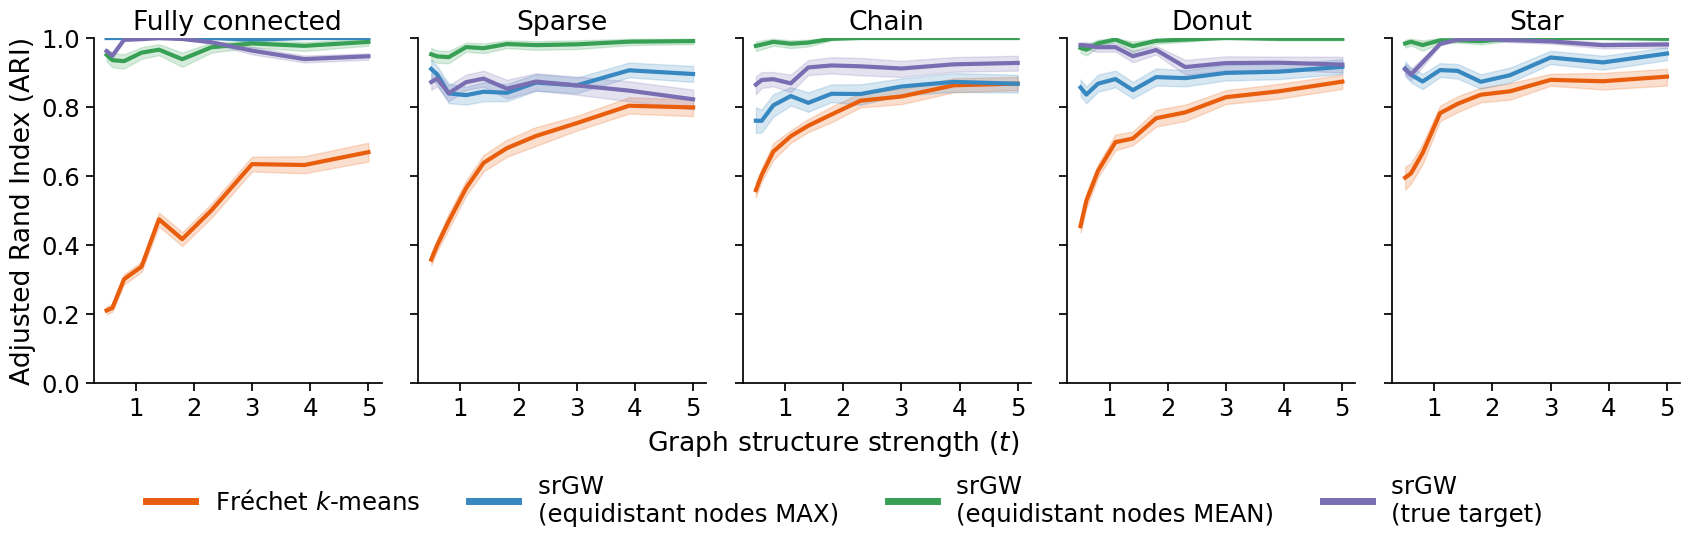

In [9]:
blues = sns.color_palette("Blues", 2)[:2]
oranges = sns.color_palette("Oranges", 2)[:2]
purples = sns.color_palette("Purples", 2)[:2]
greens = sns.color_palette("Greens", 2)[:2]

custom_palette = {
    "Frechet kmeans": oranges[1],
    "srGW - isolated nodes (max)": blues[1],
    "srGW - isolated nodes (mean)": greens[1],
    "srGW true target": purples[1],
}  

label_dict = {
    "Frechet kmeans": "Fréchet $k$-means",
    "Kernel kmeans": "Kernel $k$-means",
    "srGW - isolated nodes (max)": "srGW \n(equidistant nodes MAX)",
    "srGW - isolated nodes (mean)": "srGW \n(equidistant nodes MEAN)",
    "srGW true target": "srGW \n(true target)",
}

sns.set_context("notebook", font_scale=1.6)
order_col = ['ref', 'sparse', 'chain', 'donut', 'star']
selection = unattributed_graph[(unattributed_graph['kernel'] == False) & (unattributed_graph['balanced'] == "balanced")]
g = sns.FacetGrid(data = selection, col = 'type_graph', hue = "method", palette=custom_palette, col_order=order_col,
                  height=5, aspect=.7, sharey=True)
g.map(sns.lineplot, 'structure_force','ARI', linewidth=3)
g.set_axis_labels("", "Adjusted Rand Index (ARI)")
g.add_legend()
title_dict = {'star': 'Star', 'chain': 'Chain', 'donut' : "Donut", "ref": "Fully connected", "sparse":"Sparse"}
for ax in g.axes.flatten():
    title = ax.get_title() 
    new_title = title.split('=')[1].strip() 
    ax.set_title(title_dict[new_title])
    ax.set_ylim(0,1)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
handles, labels = g._legend_data.values(), g._legend_data.keys()
new_labels = [label_dict.get(lbl, lbl) for lbl in labels]
g._legend.remove()
plt.legend(handles, new_labels, title="", loc="upper center",
           bbox_to_anchor=(-1.9, -.2),
           ncol=4,
           frameon=False)
for legline in plt.gca().get_legend().get_lines():
    legline.set_linewidth(5)
g.fig.text(0.4, 0.06, "Graph structure strength ($t$)", ha='center')
#g.figure.savefig(f"{path_article}performance_non_attributed.png", dpi=300, bbox_inches='tight')

### Embedded
**Warning:** The following cells require that simulations have been run beforehand.

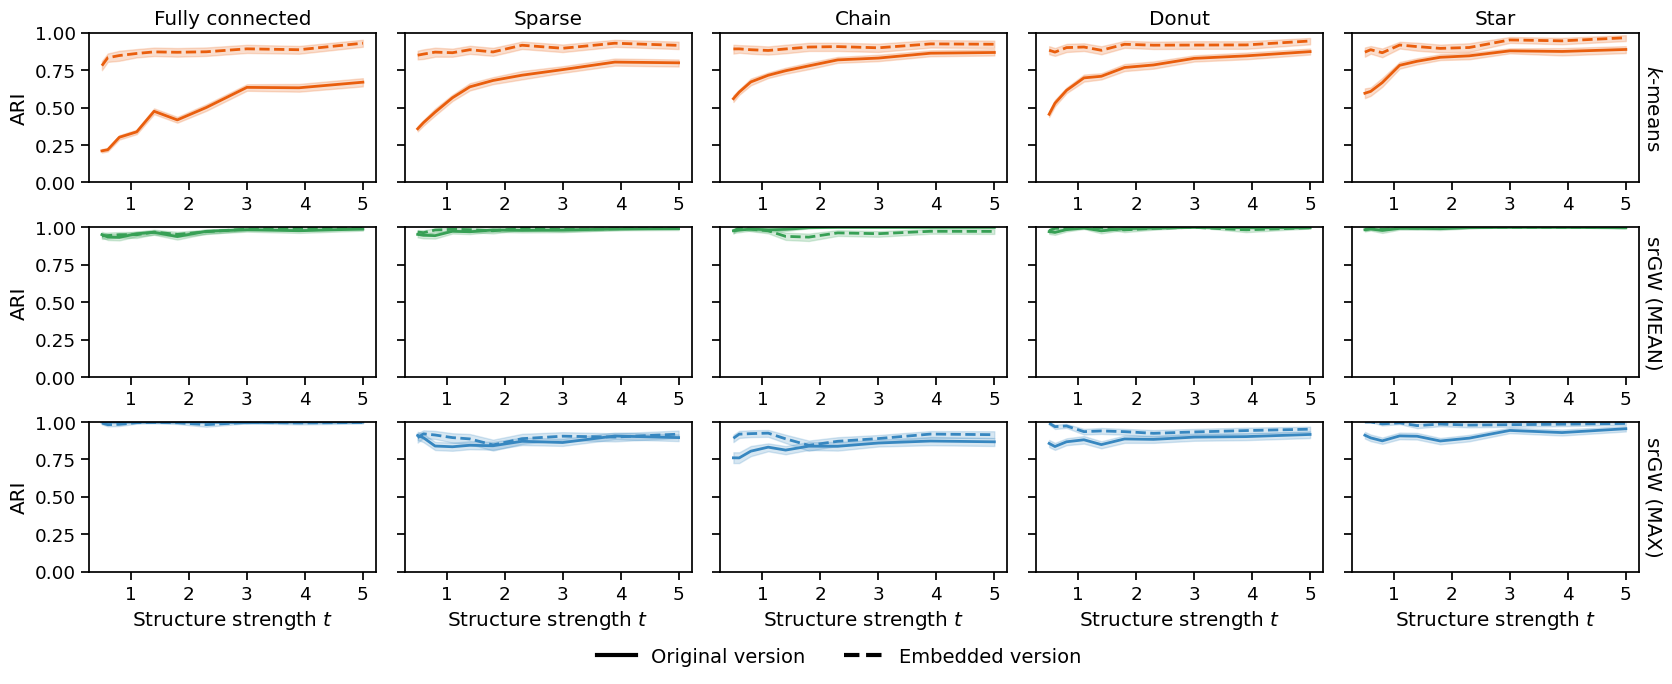

In [10]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(3,5, figure=fig, wspace=0.1, hspace=0.3)

sns.set_context("notebook", font_scale=1.2)

blues = sns.color_palette("Blues", 2)[:2]
oranges = sns.color_palette("Oranges", 2)[:2]
purples = sns.color_palette("Purples", 2)[:2]


title_dict = {'star': 'Star', 'chain': 'Chain', 'donut' : "Donut", "ref": "Fully connected", "sparse":"Sparse"}
type_graph = ['ref','sparse','chain', 'donut', 'star']
selection = unattributed_graph[(unattributed_graph['balanced'] == "balanced")]
ax0 = [fig.add_subplot(gs[0, i]) for i in range(5)]
for i, ax in enumerate(ax0):
    kmeans = selection[(selection['method'].isin(['Frechet kmeans', 'Kernel kmeans']) )&
                       (selection['type_graph'] == type_graph[i])]
    sns.lineplot(kmeans[kmeans['kernel'] ==  True], color=oranges[1],
                 x='structure_force', linestyle='--', y='ARI', linewidth = 2, ax=ax, legend=False)
    sns.lineplot(kmeans[kmeans['kernel'] ==  False], color=oranges[1],
                  x='structure_force', linestyle='-', y='ARI', linewidth = 2, ax=ax, legend=False)
    ax.set_ylim(0,1)
    ax.set_title(title_dict[type_graph[i]])
    ax.set_xlabel('')
    if i > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    if i == 4:
        ax.yaxis.set_label_position("right")
        ax.set_ylabel('$k$-means', rotation=270, va='center', labelpad=10)
ax1 = [fig.add_subplot(gs[1, i]) for i in range(5)]
for i, ax in enumerate(ax1):
    kmeans = selection[(selection['method'].isin(['srGW - isolated nodes (mean)', 'Kernel srGW - isolated nodes (mean)']) )&
                       (selection['type_graph'] == type_graph[i])]
    sns.lineplot(kmeans[kmeans['kernel'] ==  True], x='structure_force', linestyle='--',
                 color=greens[1], y='ARI', linewidth = 2, ax=ax, legend=False)
    sns.lineplot(kmeans[kmeans['kernel'] ==  False], x='structure_force',
                 color=greens[1], linestyle='-', y='ARI', linewidth = 2, ax=ax, legend=False)
    ax.set_ylim(0,1)
    ax.set_xlabel('')
    if i > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    if i == 4:
        ax.yaxis.set_label_position("right")
        ax.set_ylabel('srGW (MEAN)', rotation=270, va='center', labelpad=10)
ax2 = [fig.add_subplot(gs[2, i]) for i in range(5)]
for i, ax in enumerate(ax2):
    kmeans = selection[(selection['method'].isin(['srGW - isolated nodes (max)', 'Kernel srGW - isolated nodes (max)']) )&
                       (selection['type_graph'] == type_graph[i])]
    sns.lineplot(kmeans[kmeans['kernel'] ==  True], x='structure_force',
                 color=blues[1], linestyle='--', y='ARI', linewidth = 2, ax=ax, legend=False)
    sns.lineplot(kmeans[kmeans['kernel'] ==  False], x='structure_force',
                 color=blues[1], linestyle='-', y='ARI', linewidth = 2, ax=ax, legend=False)
    ax.set_ylim(0,1)
    ax.set_xlabel("Structure strength $t$")
    if i > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    if i == 4:
        ax.yaxis.set_label_position("right")
        ax.set_ylabel('srGW (MAX)', rotation=270, va='center', labelpad=10)
solid = mlines.Line2D([], [], color="black", linestyle='-', label='Original version')
dashed = mlines.Line2D([], [], color="black", linestyle='--', label='Embedded version')

leg = fig.legend(
    handles=[solid, dashed],
    loc="lower center",
    ncol=2,
    frameon=False,
    fontsize=14,
    bbox_to_anchor=(0.5, -0.05) 
)
for line in leg.get_lines():
    line.set_linewidth(3)

#fig.savefig(f"{path_article}non_attributed_kernel.png", dpi=300, bbox_inches='tight')


In [11]:
a = (selection[(selection['structure_force'] == selection.structure_force.min()) &
            (~selection['method'].str.contains('true'))]
 .groupby(['method','type_graph'])['ARI'].mean()
 .reset_index()
 .pivot(columns="type_graph",index="method",values="ARI")
 .reset_index())
a = a[['method'] + type_graph]
a = a.rename(columns=title_dict)
a

type_graph,method,Fully connected,Sparse,Chain,Donut,Star
0,Frechet kmeans,0.211141,0.358434,0.559578,0.455418,0.595893
1,Kernel kmeans,0.780030,0.849971,0.891704,0.882967,0.870503
2,Kernel srGW - isolated nodes (max),0.992874,0.894918,0.891778,0.992248,1.000000
3,Kernel srGW - isolated nodes (mean),0.943125,0.968800,0.975112,0.978361,0.986869
4,srGW - isolated nodes (max),1.000000,0.910448,0.760740,0.856844,0.911654
5,srGW - isolated nodes (mean),0.951420,0.952947,0.977265,0.971367,0.984190


## Attributed graph

**Warning:** The following cells require that simulations have been run beforehan

In [ ]:
import os
import glob
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator

path = "path_to_attributed_results/"
pattern = os.path.join(path, f"*.csv")
date_files = glob.glob(pattern)
attributed_graph = pd.concat((pd.read_csv(f) for f in date_files), ignore_index=True)
attributed_graph = attributed_graph[attributed_graph['groups']=='[40 40 40 40 40]']
attributed_graph['kernel'] = attributed_graph['method'].str.contains('Kernel')
attributed_graph["perturbation"] = [','.join(i) for i in zip(attributed_graph["c"].map(str),
                                                             attributed_graph["epsilon"].map(str))]
attributed_graph['perturbation'] = attributed_graph.apply(lambda x:
                                                          '1 - (1000,0.05)' if x['perturbation'] == '1000,0.05' else
                                                          ('2 - (200,0.15)' if x['perturbation'] == '200,0.15' else
                                                           ('3 - (80,0.2)' if x['perturbation'] == '80,0.2' else
                                                            ('4 - (15,0.35)' if x['perturbation'] == '15,0.35' else
                                                             ('5 - (2,2)' if x['perturbation'] == '2,2.0' else
                                                              'unknown level of perturbation')))),axis=1)


Text(0.45, 0.06, 'Graph structure strength ($t$)')

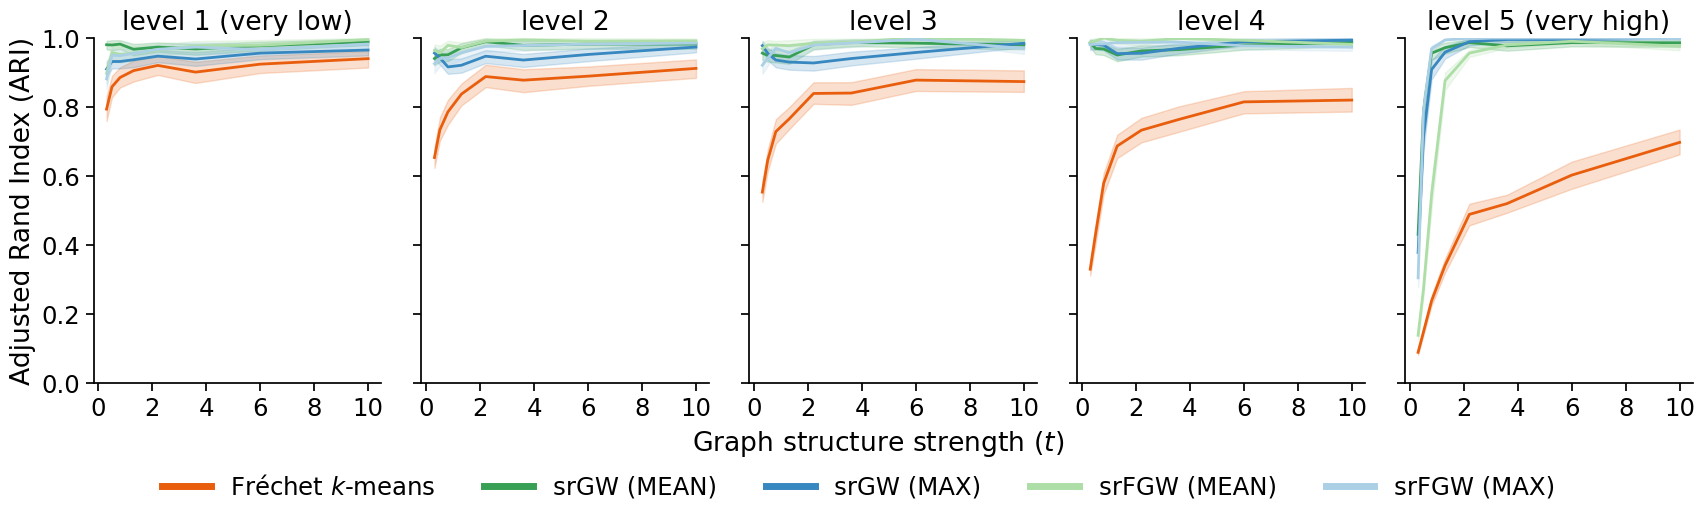

In [13]:
blues = sns.color_palette("Blues", 2)[:2]
oranges = sns.color_palette("Oranges", 2)[:2]
greens = sns.color_palette("Greens", 2)[:2]

custom_palette = {
    "Frechet kmeans": oranges[1],
    "srGW (max)": blues[1],
    "srGW (mean)": greens[1],
    "srFGW (max)": blues[0],
    "srFGW (mean)": greens[0],
}  

label_dict = {
    "Frechet kmeans": "Fréchet $k$-means",
    "srGW (max)": "srGW (MAX)",
    "srGW (mean)": "srGW (MEAN)",
    "srFGW (mean)": "srFGW (MEAN)",
    "srFGW (max)": "srFGW (MAX)",
}
title_dict = {'1 - (1000,0.05)': 'level 1 (very low)',
              '2 - (200,0.15)': 'level 2',
              '3 - (80,0.2)': 'level 3',
              '4 - (15,0.35)': 'level 4',
              '5 - (2,2)': 'level 5 (very high)'}
type_perturbation = ['1 - (1000,0.05)','2 - (200,0.15)','3 - (80,0.2)', '4 - (15,0.35)', '5 - (2,2)']


sns.set_context("notebook", font_scale=1.6)
selection = attributed_graph[(attributed_graph['kernel'] == False) & (attributed_graph['type_graph'] == "ref")]
g = sns.FacetGrid(data = selection, col = 'perturbation', hue = "method", palette=custom_palette,
                  height=5, aspect=.7, sharey=True, col_order=type_perturbation)
g.map(sns.lineplot, 'structure_force','ARI', linewidth=2)
g.set_axis_labels("", "Adjusted Rand Index (ARI)")
g.add_legend()
for ax in g.axes.flatten():
    title = ax.get_title() 
    new_title = title.split('=')[1].strip() 
    ax.set_title(title_dict[new_title])
    ax.set_ylim(0,1)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
handles, labels = g._legend_data.values(), g._legend_data.keys()
new_labels = [label_dict.get(lbl, lbl) for lbl in labels]
g._legend.remove()
plt.legend(handles, new_labels, title="", loc="upper center",
           bbox_to_anchor=(-1.9, -.2),
           ncol=5,
           frameon=False)
for legline in plt.gca().get_legend().get_lines():
    legline.set_linewidth(5) 
g.fig.text(0.45, 0.06, "Graph structure strength ($t$)", ha='center')
#g.figure.savefig(f"{path_article}performance_attributed.png", dpi=300, bbox_inches='tight')

Text(0.45, 0.06, 'Graph structure strength ($t$)')

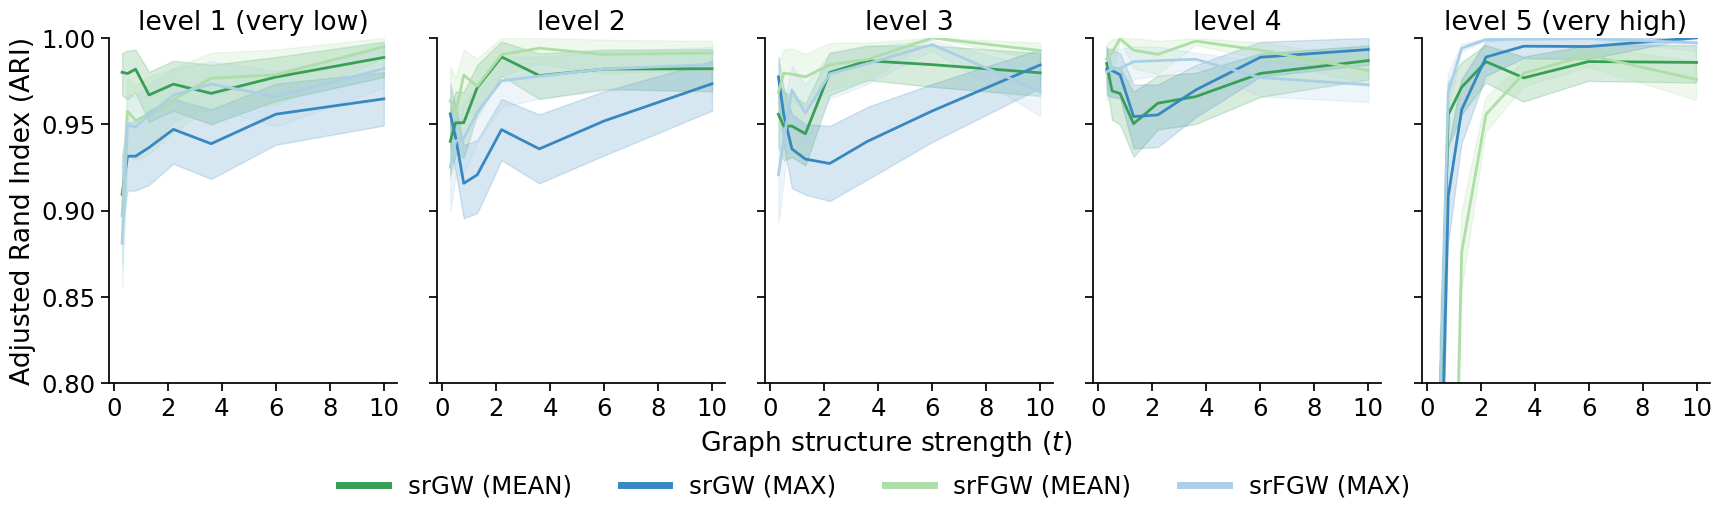

In [14]:
blues = sns.color_palette("Blues", 2)[:2]
oranges = sns.color_palette("Oranges", 2)[:2]
greens = sns.color_palette("Greens", 2)[:2]

custom_palette = {
    "Frechet kmeans": oranges[1],
    "srGW (max)": blues[1],
    "srGW (mean)": greens[1],
    "srFGW (max)": blues[0],
    "srFGW (mean)": greens[0],
}  

label_dict = {
    "Frechet kmeans": "Fréchet $k$-means",
    "srGW (max)": "srGW (MAX)",
    "srGW (mean)": "srGW (MEAN)",
    "srFGW (mean)": "srFGW (MEAN)",
    "srFGW (max)": "srFGW (MAX)",
}
title_dict = {'1 - (1000,0.05)': 'level 1 (very low)',
              '2 - (200,0.15)': 'level 2',
              '3 - (80,0.2)': 'level 3',
              '4 - (15,0.35)': 'level 4',
              '5 - (2,2)': 'level 5 (very high)'}
type_perturbation = ['1 - (1000,0.05)','2 - (200,0.15)','3 - (80,0.2)', '4 - (15,0.35)', '5 - (2,2)']


sns.set_context("notebook", font_scale=1.6)
selection = attributed_graph[(attributed_graph['kernel'] == False) & (attributed_graph['type_graph'] == "ref")
                             & (attributed_graph['method']!='Frechet kmeans')]
g = sns.FacetGrid(data = selection, col = 'perturbation', hue = "method", palette=custom_palette,
                  height=5, aspect=.7, sharey=True, col_order=type_perturbation)
g.map(sns.lineplot, 'structure_force','ARI', linewidth=2)
g.set_axis_labels("", "Adjusted Rand Index (ARI)")
g.add_legend()
for ax in g.axes.flatten():
    title = ax.get_title() 
    new_title = title.split('=')[1].strip() 
    ax.set_title(title_dict[new_title])
    ax.set_ylim(.8,1)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
handles, labels = g._legend_data.values(), g._legend_data.keys()
new_labels = [label_dict.get(lbl, lbl) for lbl in labels]
g._legend.remove()
plt.legend(handles, new_labels, title="", loc="upper center",
           bbox_to_anchor=(-1.9, -.2),
           ncol=5,
           frameon=False)
for legline in plt.gca().get_legend().get_lines():
    legline.set_linewidth(5)
g.fig.text(0.45, 0.06, "Graph structure strength ($t$)", ha='center')
#g.figure.savefig(f"{path_article}performance_attributed_zoom.png", dpi=300, bbox_inches='tight')

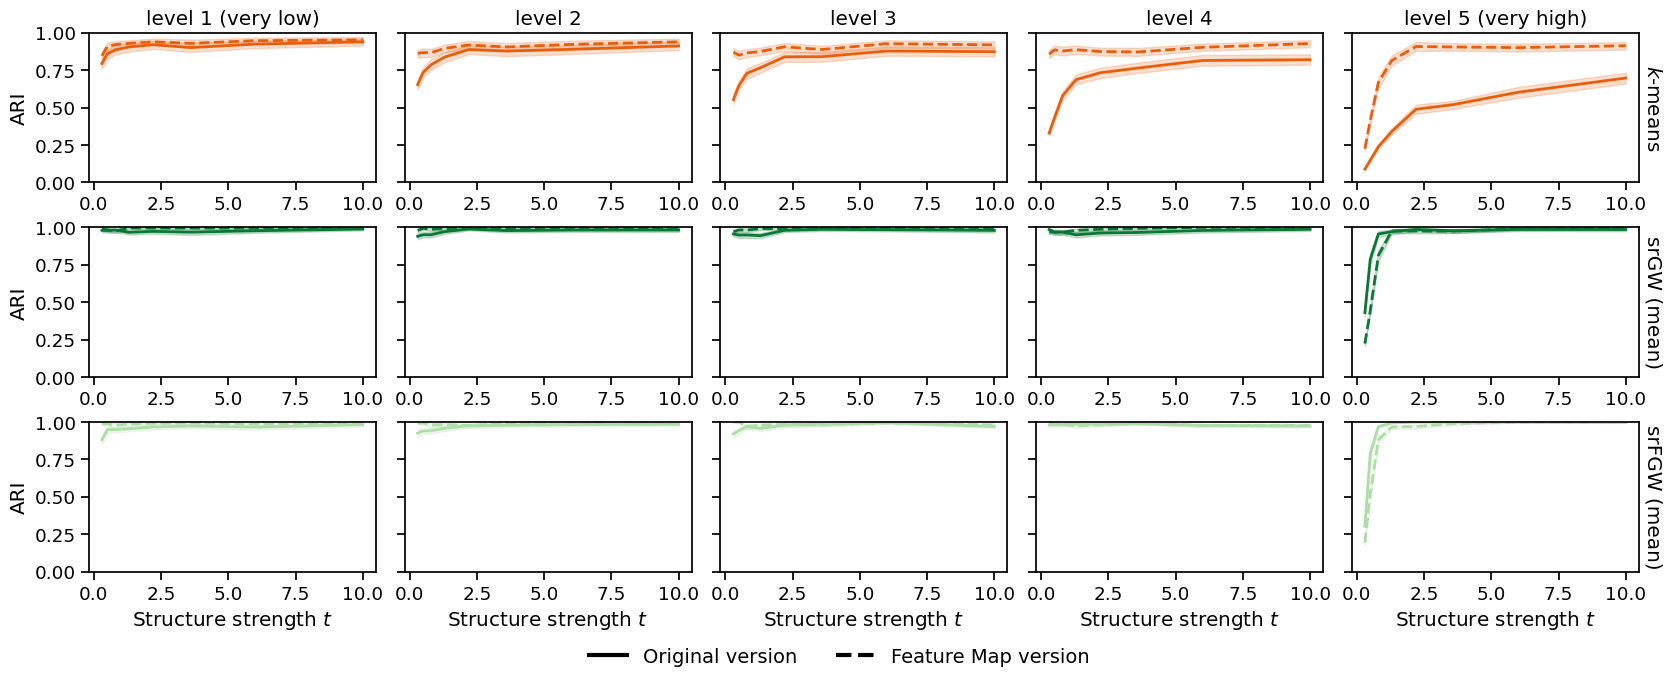

In [15]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

fig = plt.figure(figsize=(20, 7))
gs = gridspec.GridSpec(3,5, figure=fig, wspace=0.1, hspace=0.3)

sns.set_context("notebook", font_scale=1.2)

blues = sns.color_palette("Blues", 2)[:2]
oranges = sns.color_palette("Oranges", 2)[:2]
purples = sns.color_palette("Purples", 2)[:2]
greens = sns.color_palette("Greens", 5)


title_dict = {'1 - (1000,0.05)': 'level 1 (very low)',
              '2 - (200,0.15)': 'level 2',
              '3 - (80,0.2)': 'level 3',
              '4 - (15,0.35)': 'level 4',
              '5 - (2,2)': 'level 5 (very high)'}
type_perturbation = ['1 - (1000,0.05)','2 - (200,0.15)','3 - (80,0.2)', '4 - (15,0.35)', '5 - (2,2)']
selection = attributed_graph
ax0 = [fig.add_subplot(gs[0, i]) for i in range(5)]
for i, ax in enumerate(ax0):
    kmeans = selection[(selection['method'].isin(['Frechet kmeans', 'Kernel kmeans']) )&
                       (selection['perturbation'] == type_perturbation[i])]
    sns.lineplot(kmeans[kmeans['kernel'] ==  True], color=oranges[1],
                 x='structure_force', linestyle='--', y='ARI', linewidth = 2, ax=ax, legend=False)
    sns.lineplot(kmeans[kmeans['kernel'] ==  False], color=oranges[1],
                  x='structure_force', linestyle='-', y='ARI', linewidth = 2, ax=ax, legend=False)
    ax.set_ylim(0,1)
    ax.set_title(title_dict[type_perturbation[i]])
    ax.set_xlabel('')
    if i > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    if i == 4:
        ax.yaxis.set_label_position("right")
        ax.set_ylabel('$k$-means', rotation=270, va='center', labelpad=10)
ax1 = [fig.add_subplot(gs[1, i]) for i in range(5)]
for i, ax in enumerate(ax1):
    kmeans = selection[(selection['method'].isin(['srGW (mean)', 'Kernel srGW (mean)']) )&
                       (selection['perturbation'] == type_perturbation[i])]
    sns.lineplot(kmeans[kmeans['kernel'] ==  True], x='structure_force', linestyle='--',
                 color=greens[4], y='ARI', linewidth = 2, ax=ax, legend=False)
    sns.lineplot(kmeans[kmeans['kernel'] ==  False], x='structure_force',
                 color=greens[4], linestyle='-', y='ARI', linewidth = 2, ax=ax, legend=False)
    ax.set_ylim(0,1)
    ax.set_xlabel('')
    if i > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    if i == 4:
        ax.yaxis.set_label_position("right")
        ax.set_ylabel('srGW (mean)', rotation=270, va='center', labelpad=10)
ax2 = [fig.add_subplot(gs[2, i]) for i in range(5)]
for i, ax in enumerate(ax2):
    kmeans = selection[(selection['method'].isin(['srFGW (max)', 'Kernel srFGW (DDS DA) (max)']) )&
                       (selection['perturbation'] == type_perturbation[i])]
    sns.lineplot(kmeans[kmeans['kernel'] ==  True], x='structure_force',
                 color=greens[1], linestyle='--', y='ARI', linewidth = 2, ax=ax, legend=False)
    sns.lineplot(kmeans[kmeans['kernel'] ==  False], x='structure_force',
                 color=greens[1], linestyle='-', y='ARI', linewidth = 2, ax=ax, legend=False)
    ax.set_ylim(0,1)
    ax.set_xlabel("Structure strength $t$")
    if i > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    if i == 4:
        ax.yaxis.set_label_position("right")
        ax.set_ylabel('srFGW (mean)', rotation=270, va='center', labelpad=10)
solid = mlines.Line2D([], [], color="black", linestyle='-', label='Original version')
dashed = mlines.Line2D([], [], color="black", linestyle='--', label='Feature Map version')

leg = fig.legend(
    handles=[solid, dashed],
    loc="lower center",
    ncol=2,
    frameon=False,
    fontsize=14,
    bbox_to_anchor=(0.5, -0.05)
)
for line in leg.get_lines():
    line.set_linewidth(3)
#g.figure.savefig(f"{path_article}details_attributed_kernel.png", dpi=300, bbox_inches='tight')

In [16]:
a = (selection[(selection['structure_force'] == selection.structure_force.min()) &
            (~selection['method'].str.contains('true'))]
 .groupby(['method','perturbation'])['ARI'].mean()
 .reset_index()
 .pivot(columns="perturbation",index="method",values="ARI")
 .reset_index())
a = a[['method'] + type_perturbation]
a = a.rename(columns=title_dict)
pd.options.display.float_format = "{:,.3f}".format
a

perturbation,method,level 1 (very low),level 2,level 3,level 4,level 5 (very high)
0,Frechet kmeans,0.794,0.653,0.553,0.330,0.089
1,Kernel kmeans,0.846,0.862,0.870,0.857,0.225
2,Kernel srFGW (DDS DA) (max),0.989,0.993,1.000,0.995,0.194
3,Kernel srFGW (DDS DA) (mean),0.989,0.993,1.000,0.990,0.131
4,Kernel srGW (max),0.985,0.954,0.953,0.966,0.212
5,Kernel srGW (mean),0.990,0.980,0.971,0.969,0.224
6,srFGW (max),0.881,0.925,0.921,0.980,0.305
7,srFGW (mean),0.897,0.964,0.968,0.988,0.139
8,srGW (max),0.909,0.956,0.977,0.982,0.378
9,srGW (mean),0.980,0.940,0.956,0.985,0.431


In [17]:
a = (selection[(selection['structure_force'] == 6) &
            (~selection['method'].str.contains('true'))]
 .groupby(['method','perturbation'])['ARI'].mean()
 .reset_index()
 .pivot(columns="perturbation",index="method",values="ARI")
 .reset_index())
a = a[['method'] + type_perturbation]
a = a.rename(columns=title_dict)
pd.options.display.float_format = "{:,.3f}".format
a

perturbation,method,level 1 (very low),level 2,level 3,level 4,level 5 (very high)
0,Frechet kmeans,0.924,0.889,0.878,0.815,0.603
1,Kernel kmeans,0.947,0.922,0.927,0.902,0.900
2,Kernel srFGW (DDS DA) (max),0.988,0.994,0.993,0.978,0.998
3,Kernel srFGW (DDS DA) (mean),0.990,1.000,0.993,0.994,0.987
4,Kernel srGW (max),0.980,0.976,0.958,0.980,0.997
5,Kernel srGW (mean),0.995,0.995,0.998,1.000,0.991
6,srFGW (max),0.966,0.982,0.996,0.977,1.000
7,srFGW (mean),0.979,0.990,1.000,0.993,0.990
8,srGW (max),0.956,0.952,0.958,0.989,0.995
9,srGW (mean),0.977,0.982,0.984,0.979,0.986


### Fused

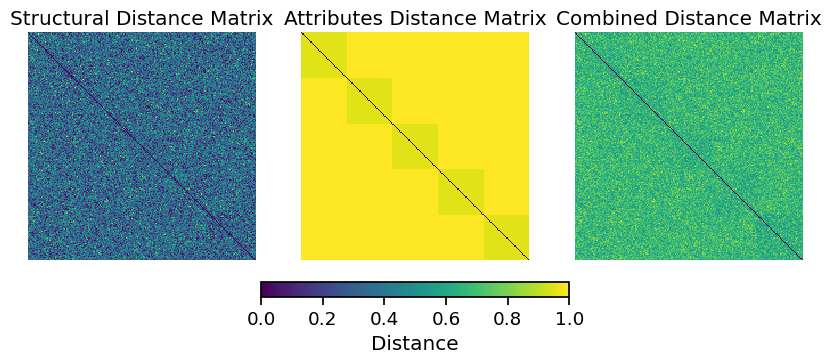

In [18]:
from src.distances import combine_alpha
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import adjusted_rand_score
from src.clustering.utils import transport_plan_to_labels
from src.clustering.init_strategies import ClusteringInit
from src.clustering.gw_clustering import SemiRelaxedGWClustering, SemiRelaxedFGWClustering

def block_matrix(group_sizes, intra, inter):
    n = sum(group_sizes)
    M = np.full((n, n), inter, dtype=float)
    start = 0
    for size in group_sizes:
        end = start + size
        M[start:end, start:end] = intra
        start = end
    np.fill_diagonal(M, 0)    
    return M

n = 200
k = 5
groups = np.array([40,40,40,40,40])

seed = 42
np.random.seed(seed)
upper_noise = abs(np.random.normal(loc=1, scale=.5, size=(n,n)))
noise = np.triu(upper_noise, 1)
noise = noise + noise.T
structural_matrix = noise/noise.max()
np.fill_diagonal(structural_matrix, 0)

attributes_matrix = block_matrix(groups, 0.2, 0.21)
#attributes_matrix = fill_random_offdiag_symmetric(attributes_matrix, 5)
attributes_matrix = attributes_matrix/attributes_matrix.max()

combined_matrix = combine_alpha(structural_matrix, attributes_matrix, alpha = 0.5)

fig, axes = plt.subplots(1, 3, figsize=(10, 4))

sns.heatmap(structural_matrix, square=True, cmap="viridis", ax=axes[0], cbar=False)
axes[0].set_axis_off()
axes[0].set_title('Structural Distance Matrix')
sns.heatmap(attributes_matrix, square=True, cmap="viridis", ax=axes[1], cbar=False)
axes[1].set_axis_off()
axes[1].set_title('Attributes Distance Matrix')
sns.heatmap(combined_matrix, square=True, cmap="viridis", ax=axes[2], cbar=False)
axes[2].set_axis_off()
axes[2].set_title('Combined Distance Matrix')
norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm = mpl.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([]) 
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.07)
cbar.set_label('Distance')
#fig.savefig(f"{path_article}fused_performance.png", dpi=300, bbox_inches='tight')

In [19]:
seed = 42
np.random.seed(seed)
results = {'srgw_max':[],
           'srgw_avg':[],
           'srfgw_max_initcombined':[],
           'srfgw_avg_initcombined':[],
           'srfgw_max_initdiff':[],
           'srfgw_avg_initdiff':[]}
true_labels = [[i] * j for i, j in enumerate(groups)]
true_labels = np.array(true_labels).flatten().tolist()
init = ClusteringInit(n, k, combined_matrix, set_seed=seed)
init_att = ClusteringInit(n, k, attributes_matrix, set_seed=seed)
for i in tqdm(range(100)):
    upper_noise = abs(np.random.normal(loc=1, scale=.5, size=(n,n)))
    noise = np.triu(upper_noise, 1)
    noise = noise + noise.T
    structural_matrix = noise/noise.max()
    np.fill_diagonal(structural_matrix, 0)

    attributes_matrix = block_matrix(groups, 0.1, 0.11)
    #attributes_matrix = fill_random_offdiag_symmetric(attributes_matrix, 5)
    attributes_matrix = attributes_matrix/attributes_matrix.max()

    combined_matrix = combine_alpha(structural_matrix, attributes_matrix, alpha = 0.5)    # init
    _, init_OT = init.embedded_kmeanspp_init()
    # srgw_max
    srgw_max = SemiRelaxedGWClustering(n, k, g0=init_OT, value=combined_matrix.max())
    srgw_max_labels = srgw_max.partitioning(structural_matrix, attributes_matrix)['labels']
    results['srgw_max'].append(adjusted_rand_score(srgw_max_labels, true_labels))
    # srgw avg
    srgw_avg = SemiRelaxedGWClustering(n, k, g0=init_OT, value=combined_matrix.mean())
    srgw_avg_labels = srgw_avg.partitioning(structural_matrix, attributes_matrix)['labels']
    results['srgw_avg'].append(adjusted_rand_score(srgw_avg_labels, true_labels))
    # fused max
    attributes_dict = {'attributes':attributes_matrix}
    srfgw_max = SemiRelaxedFGWClustering(n, k, g0=init_OT, g0_attributes=init_OT)
    srfgw_max.define_method(weights={'attributes':1}, powers={'attributes':2}, alpha=0.5)
    srfgw_max_ot = srfgw_max.iterate(structural_matrix, attributes_dict, value=structural_matrix.max(), medoid=True)['ot'][-1]
    srfgw_max_labels = transport_plan_to_labels(srfgw_max_ot)
    results['srfgw_max_initcombined'].append(adjusted_rand_score(srfgw_max_labels, true_labels))
    # fused mean
    srfgw_mean_ot = srfgw_max.iterate(structural_matrix, attributes_dict, value=structural_matrix.mean(), medoid=True)['ot'][-1]
    srfgw_mean_labels = transport_plan_to_labels(srfgw_mean_ot)
    results['srfgw_avg_initcombined'].append(adjusted_rand_score(srfgw_mean_labels, true_labels))
    # fused max
    _, init_OT_att = init_att.embedded_kmeanspp_init()
    srfgw_max = SemiRelaxedFGWClustering(n, k, g0=init_OT, g0_attributes=init_OT_att)
    srfgw_max.define_method(weights={'attributes':1}, powers={'attributes':2}, alpha=0.5)
    srfgw_max_ot = srfgw_max.iterate(structural_matrix, attributes_dict, value=structural_matrix.max(), medoid=True)['ot'][-1]
    srfgw_max_labels = transport_plan_to_labels(srfgw_max_ot)
    results['srfgw_max_initdiff'].append(adjusted_rand_score(srfgw_max_labels, true_labels))
    # fused mean
    srfgw_mean_ot = srfgw_max.iterate(structural_matrix, attributes_dict, value=structural_matrix.mean(), medoid=True)['ot'][-1]
    srfgw_mean_labels = transport_plan_to_labels(srfgw_mean_ot)
    results['srfgw_avg_initdiff'].append(adjusted_rand_score(srfgw_mean_labels, true_labels))

results_df = pd.DataFrame(results).melt()
results_df.groupby('variable')['value'].mean().reset_index()

100%|██████████| 100/100 [00:05<00:00, 18.30it/s]


,variable,value
0,srfgw_avg_initcombined,0.830
1,srfgw_avg_initdiff,0.839
2,srfgw_max_initcombined,0.080
3,srfgw_max_initdiff,0.100
4,srgw_avg,0.435
5,srgw_max,0.331
